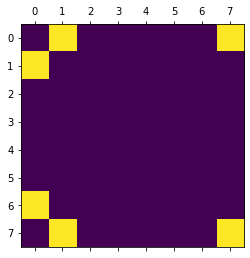

In [ ]:
import numpy as np
from threading import Thread
from threading import Lock
from threading import Condition
from threading import Semaphore
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

N = 8

matrica =  np.random.choice([0,1],N*N,p=[0.9,0.1]).reshape(N,N)
niti = [[None for i in range(N)] for j in range(N)]


steps = [matrica]

lock = Lock()
condition = Condition()
odradjeneCelije = 0

def proveriCeliju(iteracija,matrix,i,j,N):

  if(iteracija == 0):
    return matrix[(i-1)%N][(j-1)%N]
  if(iteracija == 1):
    return matrix[(i-1)%N][(j)%N]
  if(iteracija == 2):
    return matrix[(i-1)%N][(j+1)%N]
  if(iteracija == 3):
    return matrix[(i)%N][(j-1)%N]
  if(iteracija == 4):
    return matrix[(i)%N][(j+1)%N]
  if(iteracija == 5):
    return matrix[(i+1)%N][(j-1)%N]
  if(iteracija == 6):
    return matrix[(i+1)%N][(j)%N]
  if(iteracija == 7):
    return matrix[(i+1)%N][(j+1)%N]
  

class Celija(Thread):
 
  global niti
  global matrica
  global steps
  global odradjeneCelije
  global N
  global lock 
  global condition

  def __init__(self, row, col, value):
    super().__init__()
    self.row = row
    self.col = col
    self.brojac = 0
    self.value = value
    self.susedi = 0
    self.semaphore = Semaphore(0)

  def run(self):
    global N
    global odradjeneCelije
    for i in range(10):
      self.susedi = 0
      for x in range(8):
        lock.acquire()
        
        if (proveriCeliju(x,niti,self.row,self.col,N)).value == 1:
          self.susedi += 1

        (proveriCeliju(x,niti,self.row,self.col,N)).brojac += 1
        
        if (proveriCeliju(x,niti,self.row,self.col,N)).brojac == 8:
          (proveriCeliju(x,niti,self.row,self.col,N)).brojac = 0
          (proveriCeliju(x,niti,self.row,self.col,N)).semaphore.release()
          
        lock.release()

      self.semaphore.acquire()

      if self.value == 1:
        if self.susedi < 2 or self.susedi > 3:
          self.value = 0
      else:
        if self.susedi == 3:
          self.value = 1

      matrica[self.row][self.col] = self.value
      odradjeneCelije += 1
      condition.acquire()

      if odradjeneCelije == N * N:
        odradjeneCelije = 0
        step = [[0 for i in range(N)] for j in range(N)]
        for t in range(N):
            for z in range(N):
             step[t][z] = matrica[t][z]
        steps.append(step)
        condition.notify_all()
        condition.release()     
      else:
        condition.wait()
        condition.release()
        
def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim

for i in range(N):
  for j in range(N):
    niti[i][j] = Celija(i, j, matrica[i][j])

for i in range(N):
  for j in range(N):
    niti[i][j].start()

for i in range(N):
  for j in range(N):
    niti[i][j].join()

anim = animate(steps);
HTML(anim.to_html5_video())